# Utilities

In [1]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

# get ECS data

ECS data source: https://github.com/mzelinka/cmip56_forcing_feedback_ecs

In [2]:
import json
f = open('CMIP6_ECS.json','r')
data = json.load(f)

In [3]:
models = list(data['CMIP6'].keys())

In [4]:
ECSs = []
for model in models:
    ens = list(data['CMIP6'][model].keys())[0]
    ecs = data['CMIP6'][model][ens]['ECS']
    ECSs.append(ecs)

# amoc data

In [5]:
index_corr = [        np.nan,  0.65027804,  0.29037919, -0.06433695,         np.nan,
               np.nan,         np.nan,  0.62246211, -0.53742898, -0.17273195,
       -0.31922787,  0.71986495,  0.15930026, -0.79221685,  0.65540284,
        0.36555517,  0.32827242, -0.59477096,  0.29896265, -0.00379101,
       -0.60229809,         np.nan, -0.15756056, -0.7114608 ,  0.49772728,
        0.05602783, -0.50325717,         np.nan, -0.01530527,         np.nan,
       -0.55311728,         np.nan,  0.54246309,  0.16115328]
index_trend  = [ np.nan     , -0.12486832, -0.17153402,  0.1017996 ,  np.nan     ,
        np.nan     ,  np.nan     , -0.34090648,  0.31636081,  0.06544964,
       -0.28925785, -0.46253549, -0.91702241,  2.38335248, -0.71424064,
       -0.16131748, -0.19180185,  0.61087685, -0.2826538 ,  0.05493779,
        0.05520693,  np.nan     ,  0.05929514,  0.3463004 , -0.16693267,
        0.28016147,  0.41325208,  np.nan     , -0.02773479,  np.nan     ,
        0.07413273,  np.nan     , -0.59671937, -0.26554846]
strn26_corr = [           np.nan,  6.50057678e-01,  3.05680089e-01,  5.57158633e-01,
                  np.nan,            np.nan,            np.nan, -7.35324410e-01,
        8.98158584e-01, -1.36877697e-01,  9.59039670e-01, -5.25740012e-01,
        8.20449450e-01,  8.60827303e-01,  2.99961680e-01,  1.37306054e-01,
       -2.20627851e-01,  7.85779706e-01,  4.11291353e-01,  4.35189900e-01,
        2.76292840e-01,            np.nan,  7.82357459e-01,  7.18605886e-01,
        4.27657165e-01,  3.83312113e-01,  5.44128284e-01,            np.nan,
       -2.37488848e-04,            np.nan,  2.88566591e-01,            np.nan,
       -2.81777747e-01,  2.97840467e-01]
strn26_trend = [ np.nan     , -0.16305699,  0.33056267,  0.3839686 ,  np.nan     ,
        np.nan     ,  np.nan     ,  1.3983072 ,  0.66241633,  0.56884939,
       -0.41084875,  0.08171279, -1.52822658,  2.649624  , -0.24000674,
       -0.10836978,  2.73458049,  0.50596756, -0.73683428,  1.18264619,
        1.10366632,  np.nan     , -0.13148323,  1.54775164, -0.3019097 ,
        1.08639919,  1.38869263,  np.nan     ,  1.72462294,  np.nan     ,
        0.56257151,  np.nan     ,  1.15086734,  0.16937692]

In [6]:
lambda_pvs = xr.open_dataset('EWS_files/CMIP6_lambda_pvs.nc')
lambda_trends = xr.open_dataset('EWS_files/CMIP6_lambda_trends.nc')
index_lam_pv = lambda_pvs.index_pvs[:,0].values
strn26_lam_pv = lambda_pvs.strn26_pvs[:,0].values
index_lam_trend = lambda_trends.index_trends[:,0].values
strn26_lam_trend = lambda_trends.strn26_trends[:,0].values

# make data for M20 models

In [7]:
M20_models = ['AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'FGOALS-f3-L', 'FGOALS-g3', 'IITM-ESM', 'CanESM5', 'CNRM-CM6-1',
       'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'E3SM-1-1', 'EC-Earth3',
       'EC-Earth3-Veg', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'MIROC6', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM',
       'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2',
       'CESM2-WACCM', 'NorESM1-F', 'NorESM2-LM', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-ESM4', 'NESM3', 'SAM0-UNICON']

In [8]:
M20_ECSs = []
M20_Emodels = []
index_corr2 = []
strn26_corr2 = []
index_trend2 = []
strn26_trend2 = []
index_lam_pv2 = []
strn26_lam_pv2 = []
index_lam_trend2 = []
strn26_lam_trend2 = []
for i, model in enumerate(M20_models):
    try:
        ens = list(data['CMIP6'][model].keys())[0]
        ecs = data['CMIP6'][model][ens]['ECS']
        if not np.isnan(strn26_corr[i]):
            M20_Emodels.append(model)
            M20_ECSs.append(ecs)
            index_corr2.append(index_corr[i])
            strn26_corr2.append(strn26_corr[i])
            index_trend2.append(index_trend[i])
            strn26_trend2.append(strn26_trend[i])
            index_lam_trend2.append(index_lam_trend[i])
            strn26_lam_trend2.append(strn26_lam_trend[i])
            if index_lam_pv[i]<0.06:
                index_lam_pv2.append(True)
            else:
                index_lam_pv2.append(False)
            if strn26_lam_pv[i]<0.06:
                strn26_lam_pv2.append(True)
            else:
                strn26_lam_pv2.append(False)
    except:
        print(model)

E3SM-1-1
FIO-ESM-2-0
NorESM1-F
GFDL-AM4


# values from observations

In [9]:
data2_c = pd.read_excel('caesar2021_Data_compilation.xlsx',sheet_name='Caesar et al. (2018)',skiprows=1)
oyear=data2_c['year']
oindex=data2_c['AMOC proxy [K]']
otrend, intercept, r, p, se = linregress(oyear, oindex)


oamoc_low = gaussian_filter1d(oindex, 10)
lam = run_fit_a_ar1(np.array((oindex-oamoc_low)[5:-5]),70)
bound = 70 // 2
tt = oyear[5:-5][bound:-bound]
p0, p1 = np.polyfit(tt[:-2], lam[bound:-bound][:-2], 1)
pv = kendall_tau_test(lam[bound:-bound][:-2], 10000, p0)
o_lambda_trend = p0
o_lambda_pv = pv

slope, intercept, r, p, se = linregress(oyear, oindex)
o_trend = slope*100

# %matplotlib inline
# fig = plt.figure(figsize = (20,8))
# ax = fig.add_subplot(111)

# ax.plot(oyear[5:-5],lam,color='C0')
# ax.plot(tt,tt*p0+p1,linestyle='--',color='C0',label='p={:.2f}'.format(o_lambda_pv))
# # plt.xlim(1880,2022)
# ax.set_ylabel('AMOC $\lambda$')
# ax.set_xlabel('Year')
# ax.set_title('C18 observations - gaussian trend removed')
# ax.legend(bbox_to_anchor=(0.05, 0.7), loc='lower left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False)
# plt.show()

# Plots

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


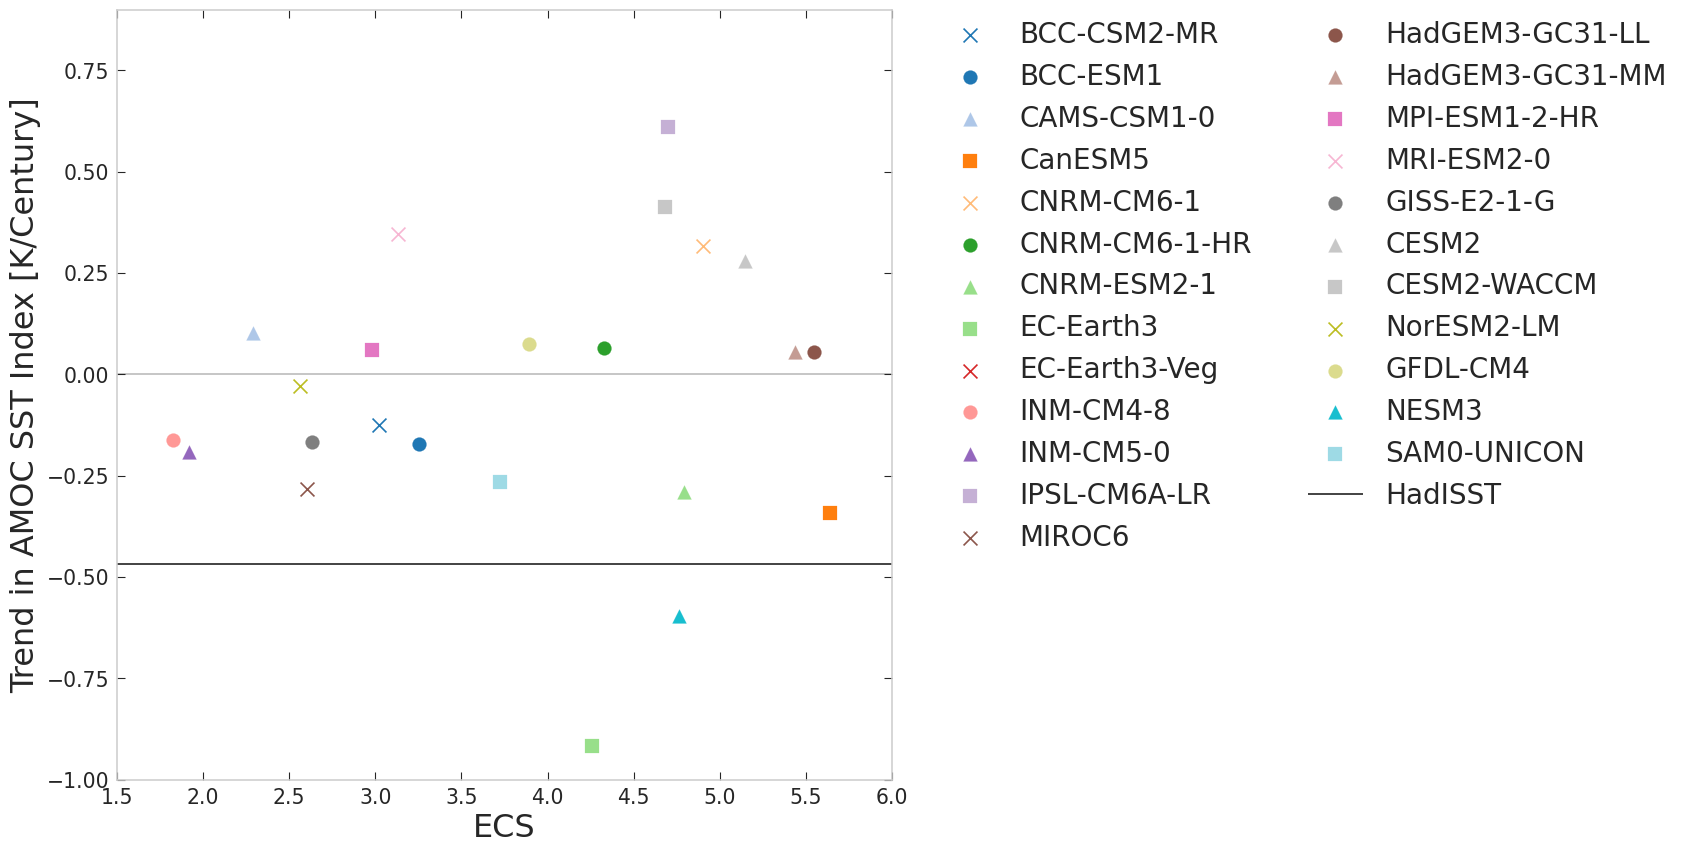

In [10]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/24) for i in np.arange(0,24)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(M20_Emodels):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(M20_ECSs[i],index_trend2[i],color=col,label=mod,marker=marker,s=100)
ax.set_xlim(1.5,6)
ax.set_ylim(-1,0.9)
plt.hlines(o_trend,-10,10,color='k',label='HadISST')
plt.hlines(0,-10,10,color='k',alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.ylabel('Trend in AMOC SST Index [K/Century]')
plt.xlabel('ECS')
plt.title('')
plt.show()

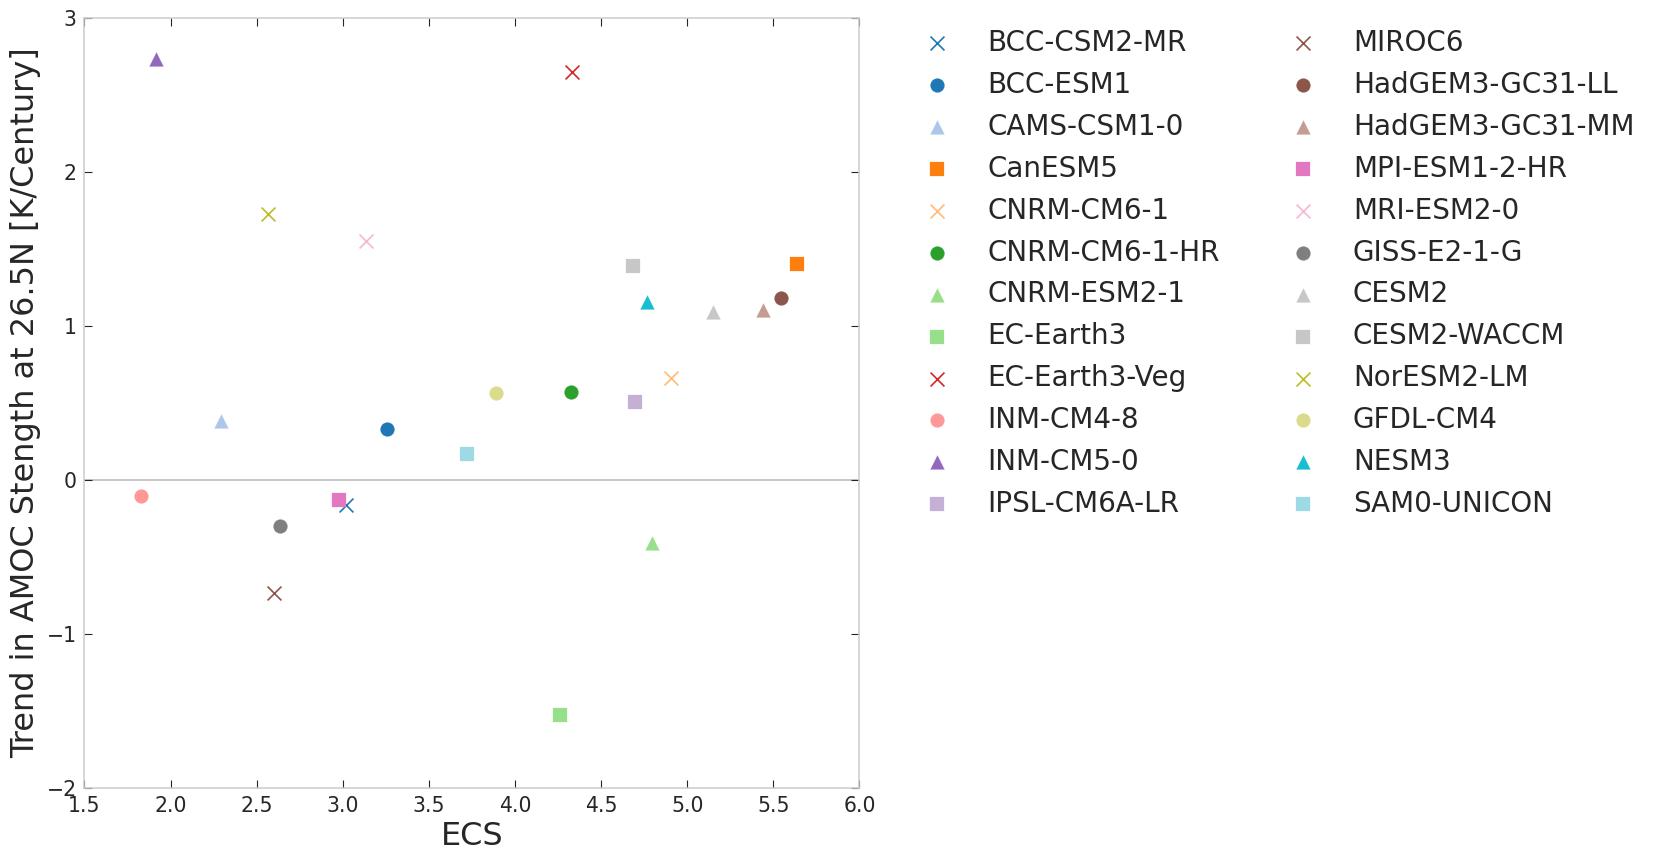

In [11]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/24) for i in np.arange(0,24)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(M20_Emodels):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(M20_ECSs[i],strn26_trend2[i],color=col,label=mod,marker=marker,s=100)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
ax.set_xlim(1.5,6)
ax.set_ylim(-2,3)
plt.hlines(0,-10,10,color='k',alpha=0.3)
plt.ylabel('Trend in AMOC Stength at 26.5N [K/Century]')
plt.xlabel('ECS')
plt.title('')
fig.patch.set_facecolor("white")
plt.show()

In [12]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/24) for i in np.arange(0,24)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(M20_Emodels):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(M20_ECSs[i],index_lam_trend2[i],color=col,label=mod,marker=marker,s=100)
plt.hlines(o_lambda_trend,-10,10,color='k',label='HadISST')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
ax.set_xlim(1.5,6)
ax.set_ylim(-0.006,0.007)
plt.hlines(0,-10,10,color='k',alpha=0.3)
plt.ylabel('Trend in $\lambda$ \nof AMOC SST Index')
plt.xlabel('ECS')
plt.title('')
plt.show()

In [13]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/24) for i in np.arange(0,24)]
markers = ['x','o','^','s']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i, mod in enumerate(M20_Emodels):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(M20_ECSs[i],strn26_lam_trend2[i],color=col,label=mod,marker=marker,s=100)
ax.set_xlim(1.5,6)
ax.set_ylim(-0.007,0.007)
plt.hlines(0,-10,10,color='k',alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.ylabel('Trend in $\lambda$ \nof AMOC Strength at 26.5N')
plt.xlabel('ECS')
plt.title('')
plt.show()

# categorise models by EWS

NameError: name 'strn_lam_pv2' is not defined

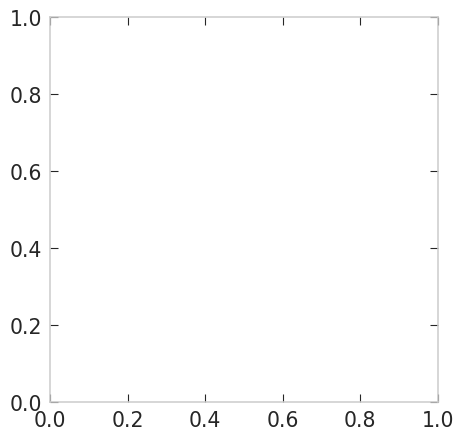

In [14]:
# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(111)
# ax.scatter(M20_ECSs,index_corr2)
# plt.show()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(len(M20_ECSs)):
    if strn_lam_pv2[i] & index_lam_pv2[i]:
        ax.scatter(M20_ECSs[i],amoc_corr2[i],color='C0',marker='s')
    elif strn_lam_pv2[i] & (not index_lam_pv2[i]):
        ax.scatter(M20_ECSs[i],amoc_corr2[i],color='C1',marker='^')
    elif (not strn_lam_pv2[i]) & index_lam_pv2[i]:
        ax.scatter(M20_ECSs[i],amoc_corr2[i],color='C2',marker='^')
    else:
        ax.scatter(M20_ECSs[i],amoc_corr2[i],color='C3',marker='s')
#     ax.annotate(M20_Emodels[i], (M20_ECSs[i],amoc_corr2[i]),fontsize=8)

ax.scatter(10,1.5,color='C0',marker='s',label='Both Strength and Index')
ax.scatter(10,1.5,color='C1',marker='^',label='Only Strength')
ax.scatter(10,1.5,color='C2',marker='^',label='Only Index')
ax.scatter(10,1.5,color='C3',marker='s',label='Neither')

ax.set_xlim(1,6)
ax.set_ylim(-1,1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10,fancybox=False,frameon=False,title='Increasing $\lambda$')
# slope, intercept, r, p, se = linregress(M20_ECSs, amoc_corr2)
# xx = np.linspace(2,6,100)
# ax.plot(xx,intercept+xx*slope,color='C1')
plt.ylabel('Decadal Cor(modelled AMOC strength \n at 26.5N, modelled AMOC index)',fontsize=10)
plt.xlabel('Equilibrium Climate Sensitivity',fontsize=10)
plt.show()

In [ ]:
# fig = plt.figure(figsize=(5,5))
# ax = fig.add_subplot(111)
# ax.scatter(M20_ECSs,index_corr2)
# plt.show()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(len(M20_ECSs)):
    if strn_lam_pv2[i] & index_lam_pv2[i]:
        ax.scatter(index_corr2[i],amoc_corr2[i],color='C0',marker='s')
    elif strn_lam_pv2[i] & (not index_lam_pv2[i]):
        ax.scatter(index_corr2[i],amoc_corr2[i],color='C1',marker='^')
    elif (not strn_lam_pv2[i]) & index_lam_pv2[i]:
        ax.scatter(index_corr2[i],amoc_corr2[i],color='C2',marker='^')
    else:
        ax.scatter(index_corr2[i],amoc_corr2[i],color='C3',marker='s')
    ax.annotate(M20_Emodels[i], (index_corr2[i],amoc_corr2[i]),fontsize=5)

ax.scatter(10,1.5,color='C0',marker='s',label='Both Strength and Index')
ax.scatter(10,1.5,color='C1',marker='^',label='Only Strength')
ax.scatter(10,1.5,color='C2',marker='^',label='Only Index')
ax.scatter(10,1.5,color='C3',marker='s',label='Neither')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10,fancybox=False,frameon=False,title='Increasing $\lambda$')
# slope, intercept, r, p, se = linregress(M20_ECSs, amoc_corr2)
# xx = np.linspace(2,6,100)
# ax.plot(xx,intercept+xx*slope,color='C1')
plt.ylabel('Decadal Cor(modelled AMOC strength \n at 26.5N, modelled AMOC index)',fontsize=10)
plt.xlabel('Decadal Cor(observed AMOC index, modelled AMOC index)',fontsize=10)
plt.show()